In [248]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [249]:
import os.path
import glob
import json
import pandas as pd
import re
import seaborn as sns

In [250]:
EXPERIMENT_NAME = '8-1-bachbot-questions'
RESPONSES_PATH = os.path.join('/home/fl350/data/responses', EXPERIMENT_NAME)

MASK_ORDER = ['S', 'A', 'T', 'B', 'AT', 'ATB', 'SATB']
AGE_GROUP_ORDER = ['under18', '18to25', '26to45', '46to60', 'over60']
MUSIC_EXPERIENCE_ORDER = ['novice', 'intermediate', 'advanced', 'expert']
ORDERS = {
    'maskedParts': MASK_ORDER,
    'ageGroup': AGE_GROUP_ORDER,
    'musicExperience': MUSIC_EXPERIENCE_ORDER
}

In [251]:
def exact_CI(x, N, alpha=0.95):
    """
    Calculate the exact confidence interval of a proportion 
    where there is a wide range in the sample size or the proportion.

    This method avoids the assumption that data are normally distributed. The sample size
    and proportion are desctibed by a beta distribution.

    Parameters
    ----------

    x: the number of cases from which the proportion is calulated as a positive integer.

    N: the sample size as a positive integer.

    alpha : set at 0.95 for 95% confidence intervals.

    Returns
    -------
    The proportion with the lower and upper confidence intervals as a dict.

    """
    from scipy.stats import beta
    x = float(x)
    N = float(N)
    p = round((x/N),2)

    intervals = [round(i,4) for i in beta.interval(alpha,x,N-x+1)]
    intervals.insert(0,p)

    result = {
        'Proportion': p,
        'Lower CI': np.minimum(np.maximum(0.0, intervals[1]), 1.0) - p,
        'Upper CI': np.maximum(0.0, np.minimum(1.0, intervals[2])) - p
    }

    return result

In [252]:
def get_mask(response):
    names = map(lambda c: c['name'], response['choices'])
    name = (n for n in names if re.match(".*-mask-.*|^out-.*", n)).next()
    if name[:3] == 'out':
        return 'SATB'
    else:
        parts = name[:-4].split('-')
        return ''.join(map(lambda x: x[0], parts[parts.index('mask')+1:parts.index('fermatas')]))

In [253]:
def get_name(response):
    names = map(lambda c: c['name'], response['choices'])
    orig_name = '-'.join((n for n in names if re.match(".*-nomask-.*", n)).next().split('-')[:2])
    gen_name = '-'.join((n for n in names if re.match(".*-mask-.*|^out-.*", n)).next().split('-')[:2]) \
        + '-' + get_mask(response)
    return orig_name + ' vs ' + gen_name

In [254]:
def is_correct(response):
    return response['choiceIndex'] == response['correctIndex']

In [255]:
def process_responses(responses):
    for response in responses:
        yield get_name(response), get_mask(response), is_correct(response)

In [256]:
def first_attempt_by_ip(blobs):
    return pd.DataFrame(blobs.groupby('ip').aggregate(lambda gp: gp.sort_values('datetime').iloc[0]))

In [257]:
def make_error_bars(props):
    return np.abs(np.concatenate(
        (props['Lower CI'].values[np.newaxis,:],
        props['Upper CI'].values[np.newaxis,:]),
        axis=0)[np.newaxis,:,:])
    
def make_error_bars2(props):
    return np.abs(np.swapaxes(
        np.swapaxes(
            np.concatenate(
                (props['Lower CI'].values[:,:,np.newaxis],
                props['Upper CI'].values[:,:,np.newaxis]),
                axis=2),
            0,1),
    1,2))

In [258]:
blobs = [json.load(open(fp, 'r')) for fp in glob.glob(RESPONSES_PATH + '/*')]

In [259]:
first_attempt_by_ip(pd.DataFrame(blobs)).shape[0]

492

In [260]:
df = pd.DataFrame(
    [(ip, name, maskedParts, correct) + tuple(row.userInfo.values())
     for ip, row in first_attempt_by_ip(pd.DataFrame(blobs)).iterrows()
     for name, maskedParts, correct in process_responses(row.responses)],
    columns=('ip','name','maskedParts','correct','musicExperience','ageGroup'))
for col, order in ORDERS.items():
    df[col] = df[col].astype('category').cat.reorder_categories(order, ordered=True)
df.head()

,ip,name,maskedParts,correct,musicExperience,ageGroup
0,100.11.25.110:60070,BWV-381 vs BWV-381-AT,AT,True,novice,18to25
1,100.11.25.110:60070,BWV-383 vs out-33.mp3-SATB,SATB,False,novice,18to25
2,100.11.25.110:60070,BWV-419 vs BWV-419-S,S,True,novice,18to25
3,100.11.25.110:60070,BWV-270 vs BWV-270-ATB,ATB,True,novice,18to25
4,100.11.25.110:60070,BWV-56.5 vs out-54.mp3-SATB,SATB,True,novice,18to25


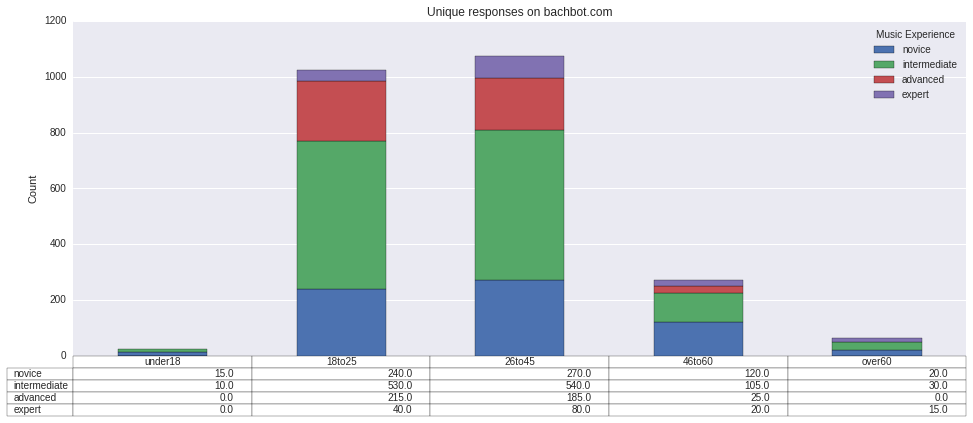

In [261]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,6)
ax.get_xaxis().set_visible(False)   # Hide Ticks

df\
.groupby(["ageGroup", "musicExperience"])\
.apply(len)\
.unstack(1)\
.loc[ORDERS['ageGroup']]\
[ORDERS['musicExperience']]\
.fillna(0)\
.plot.bar(
    ax=ax, table=True,
    stacked=True)
ax.set_title('Unique responses on bachbot.com')
ax.set_ylabel('Count')
ax.legend(title="Music Experience", loc='best')
fig.show()
fig.savefig('responses-ageGroup-musicExperience.png')

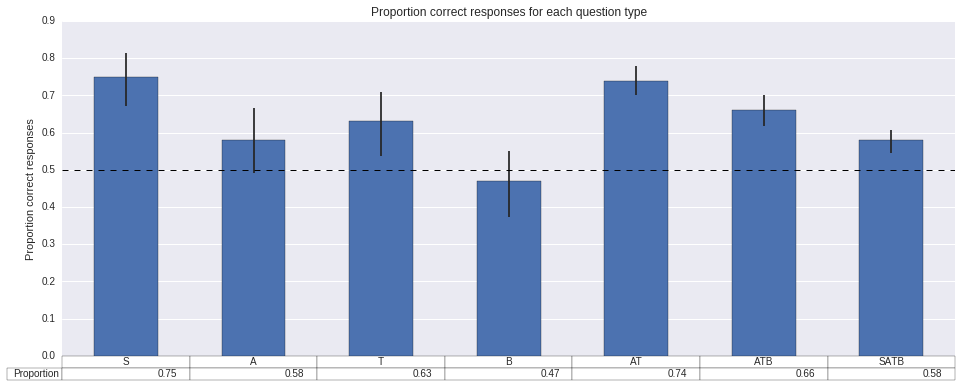

In [262]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16
                    ,6)
ax.get_xaxis().set_visible(False)   # Hide Ticks

props = df\
.groupby(["maskedParts"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\

props.plot.bar(
    y='Proportion',
    ax=ax, table=True,
    yerr=make_error_bars(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Proportion correct responses for each question type')
ax.set_ylabel('Proportion correct responses')
ax.legend().remove()
fig.show()
fig.savefig('responses-mask.png')

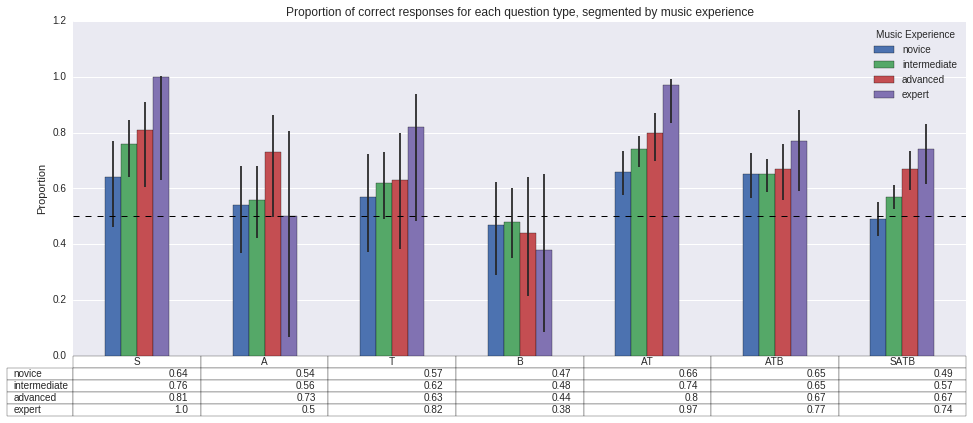

In [263]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,6)
ax.get_xaxis().set_visible(False)   # Hide Ticks

props = df\
.groupby(["maskedParts", "musicExperience"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\
.unstack(1)\
.loc[ORDERS['maskedParts']]

props.plot.bar(
    y='Proportion',
    ax=ax, table=True,
    yerr=make_error_bars2(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Proportion of correct responses for each question type, segmented by music experience')
ax.set_ylabel('Proportion')
ax.legend(title="Music Experience", loc='best')
fig.show()
fig.savefig('responses-mask-musicExperience.png')

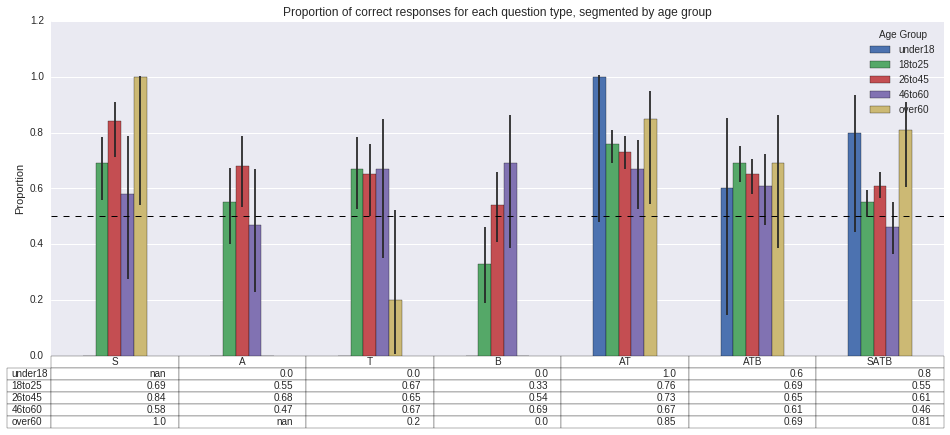

In [264]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,6)
ax.get_xaxis().set_visible(False)   # Hide Ticks

props = df\
.groupby(["maskedParts", "ageGroup"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\
.unstack(1)\
.loc[ORDERS['maskedParts']]

props.plot.bar(
    y='Proportion',
    ax=ax, table=True,
    yerr=make_error_bars2(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Proportion of correct responses for each question type, segmented by age group')
ax.set_ylabel('Proportion')
ax.legend(title="Age Group", loc='best')
fig.show()
fig.savefig('responses-mask-agegroup.png')

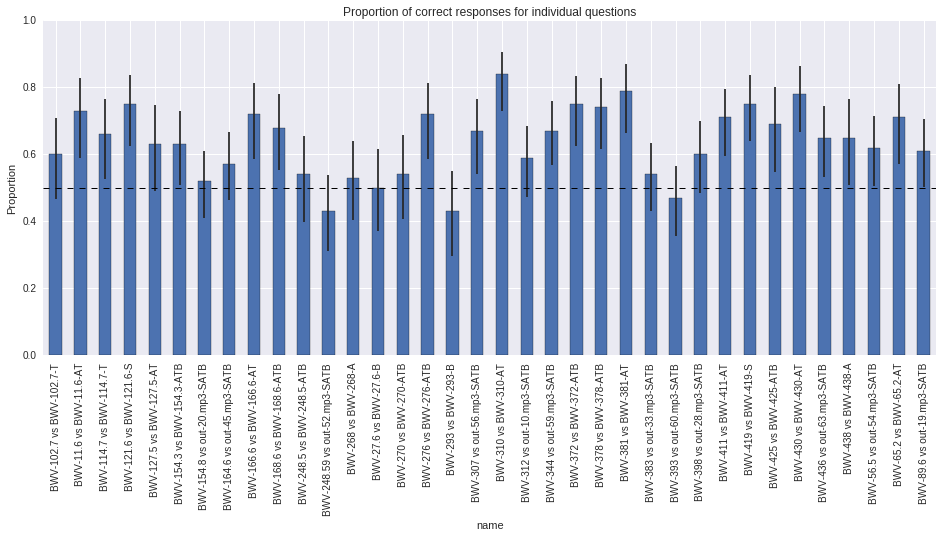

In [265]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,6)

props = df\
.groupby("name")\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))

props.plot.bar(
    y='Proportion',
    ax=ax,
    yerr=make_error_bars(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Proportion of correct responses for individual questions')
ax.set_ylabel('Proportion')
ax.legend().remove()
fig.show()
fig.savefig('responses-name.png')